> [View this Notebook on Kaggle](https://www.kaggle.com/code/nabeelvalley/forecasting-with-sktime)

# Forecasting with SKTime

> [SKTime Docs](https://www.sktime.org/)

![SKTime Tasks](https://raw.githubusercontent.com/sktime/sktime-tutorial-pydata-global-2021/main/images/reduction-relations.png)

## Resources

- [Overview of time series analysis Python packages](https://siebert-julien.github.io/time-series-analysis-python/)
- [sktime - A Unified Toolbox for ML with Time Series - Markus Löning | PyData Global 2021](https://www.youtube.com/watch?v=ODspi8-uWgo)
- [GitHub SKTime Tutorial](https://github.com/sktime/sktime-tutorial-pydata-global-2021)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nab/README.md
/kaggle/input/nab/realKnownCause/realKnownCause/rogue_agent_key_updown.csv
/kaggle/input/nab/realKnownCause/realKnownCause/ec2_request_latency_system_failure.csv
/kaggle/input/nab/realKnownCause/realKnownCause/ambient_temperature_system_failure.csv
/kaggle/input/nab/realKnownCause/realKnownCause/nyc_taxi.csv
/kaggle/input/nab/realKnownCause/realKnownCause/rogue_agent_key_hold.csv
/kaggle/input/nab/realKnownCause/realKnownCause/machine_temperature_system_failure.csv
/kaggle/input/nab/realKnownCause/realKnownCause/cpu_utilization_asg_misconfiguration.csv
/kaggle/input/nab/realTraffic/realTraffic/TravelTime_387.csv
/kaggle/input/nab/realTraffic/realTraffic/speed_6005.csv
/kaggle/input/nab/realTraffic/realTraffic/speed_t4013.csv
/kaggle/input/nab/realTraffic/realTraffic/occupancy_t4013.csv
/kaggle/input/nab/realTraffic/realTraffic/speed_7578.csv
/kaggle/input/nab/realTraffic/realTraffic/occupancy_6005.csv
/kaggle/input/nab/realTraffic/realTraffic/TravelTime_451.

In [2]:
!pip install sktime
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.5 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import sktime as sktime
import matplotlib.pyplot as plt

The basic workflow when using SKTime is as follows:

1. Specify data
2. Specify task
3. Specify model
4. Fit
5. Predict

SKTime also provides some sample datasets and other utilities under the `sktime` namespace:

In [4]:
from sktime.datasets import load_shampoo_sales
from sktime.utils.plotting import plot_series

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

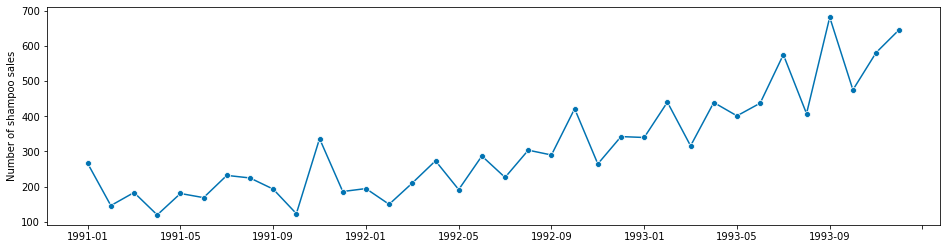

In [5]:
df_shampoo = load_shampoo_sales()
plot_series(df_shampoo)

## Forecasting

Forecasting works by taking the input data and trying to calculate what the data will be after X time period

This requires us to define a `ForecastingHorizon` which is the period of time over which we want to predict. `sktime` also has helpers for these

In [6]:
from sktime.forecasting.base import ForecastingHorizon

In [7]:
# timeframe to predict from
prediction_start = df_shampoo[-6:].index[0]

prediction_range = pd.period_range(prediction_start.start_time, freq=prediction_start.freqstr, periods=6)

prediction_range

PeriodIndex(['1993-07', '1993-08', '1993-09', '1993-10', '1993-11', '1993-12'], dtype='period[M]')

In [8]:
fh_shampoo = ForecastingHorizon(
    prediction_range,
    is_relative=False
)

In [9]:
train_cutoff = df_shampoo[-6:].index[0]

train_cutoff

Period('1993-07', 'M')

## Train/Test Split

Splitting train and test data can be done by specifying the forecasting horizon, this will return a test set and train set where the test set is in the forecasting horizon

In [10]:
from sktime.forecasting.model_selection import temporal_train_test_split

In [11]:
y_train, y_test = temporal_train_test_split(df_shampoo, fh=fh_shampoo)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

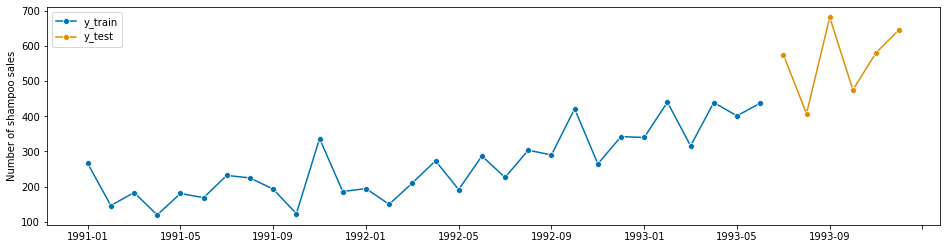

In [12]:
plot_series(y_train, y_test, labels=["y_train", "y_test"])

## Forecasting Based on Test/Train Data

This is done similar to `sklearn` models:

1. Instantiate model
2. Fit model
3. Predict
4. Evaluate

To enable this methodology, `sktime` provides different forecasting models that can be used. Below is an example using a `NaiveForecaster`:

In [13]:
from sktime.forecasting.naive import NaiveForecaster
NaiveForecaster?

In [14]:
forecaster = NaiveForecaster(strategy="drift", window_length=10)
forecaster.fit(y_train)

NaiveForecaster(strategy='drift', window_length=10)

Once fitted, generate predictions using the `ForecastingHorizon` that was defined for the prediction period

In [15]:
y_pred = forecaster.predict(fh_shampoo)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

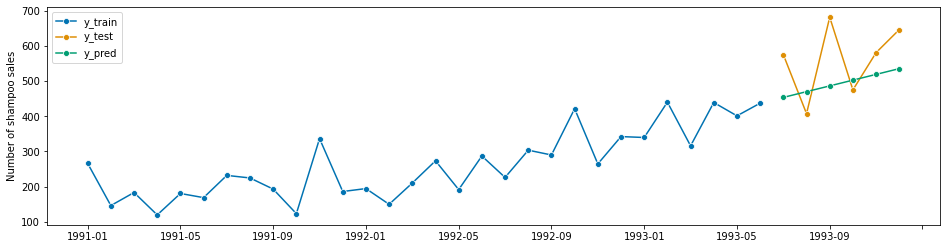

In [16]:
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

## Model Evaluation

In [17]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error

In [18]:
mean_absolute_percentage_error(y_test, y_pred)

0.16469764622516225

## ARIMA Example

We can also use an ARIMA model for example as follows:

In [19]:
from sktime.forecasting.arima import AutoARIMA

In [20]:
# sp=12 for monthly data seasonality
forecaster = AutoARIMA(sp=12, suppress_warnings=True)
forecaster.fit(y_train)

AutoARIMA(sp=12, suppress_warnings=True)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of shampoo sales'>)

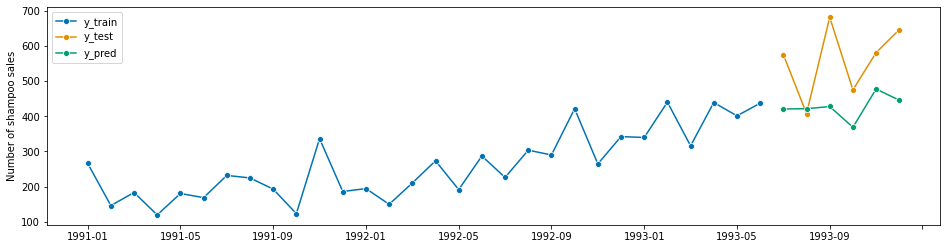

In [21]:
y_pred = forecaster.predict(fh=fh_shampoo)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

## Using SKLearn Regressors

`sktime` also supports using `sklearn` regressors and supports transforming them into time-series compatible regressors by way of the `make_reduction` function:

In [22]:
from sklearn.neighbors import KNeighborsRegressor
from sktime.forecasting.compose import make_reduction

from sktime.datasets import load_airline
airline_df = load_airline()

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

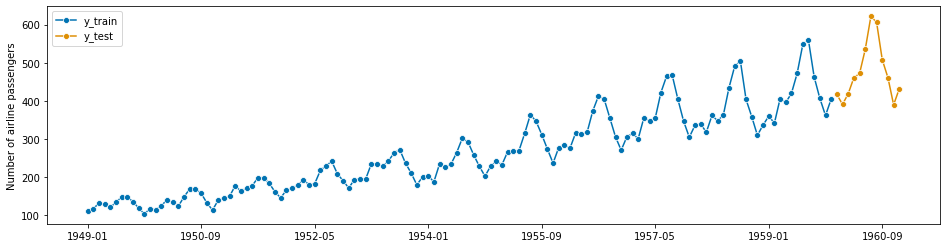

In [23]:
y_train, y_test = temporal_train_test_split(airline_df, test_size=12)
plot_series(y_train, y_test, labels=["y_train", "y_test"])

In [24]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

transform a regressor into a forecaster

In [25]:
regressor = KNeighborsRegressor(n_neighbors=3)
forecaster = make_reduction(regressor, strategy="recursive", window_length=12)

In [26]:
forecaster.fit(y_train, fh=fh)

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(n_neighbors=3),
                                     window_length=12)

(<Figure size 1152x288 with 1 Axes>,
 <AxesSubplot:ylabel='Number of airline passengers'>)

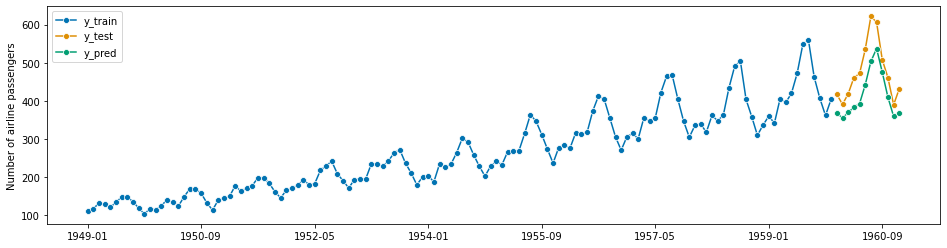

In [27]:
y_pred = forecaster.predict(fh=fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])